In [2]:
from google.colab import files
uploaded = files.upload()

Saving amazon.csv to amazon.csv


**Product reviews are becoming more important with the evolution of traditional brick and mortar retail stores to online shopping. Consumers are posting reviews directly on product pages in real time. With the vast amount of consumer reviews, this creates an opportunity to see how the market reacts to a specific product. We will be attempting to see if we can predict the sentiment of a product review using machine learning.**

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") # Plotting style
np.random.seed(7) # seeding random number generator

df = pd.read_csv('amazon.csv')
print(df.head())

                     id  ... reviews.username
0  AVqkIhwDv8e3D1O-lebb  ...          Adapter
1  AVqkIhwDv8e3D1O-lebb  ...           truman
2  AVqkIhwDv8e3D1O-lebb  ...            DaveZ
3  AVqkIhwDv8e3D1O-lebb  ...           Shacks
4  AVqkIhwDv8e3D1O-lebb  ...        explore42

[5 rows x 21 columns]


**Describing the Dataset**

In [7]:
data = df.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

**We need to clean up the name column by referencing asins (unique products) since we have 7000 missing values**

In [9]:
data["asins"].unique()

array(['B01AHB9CN2', 'B00VINDBJK', 'B005PB2T0S', 'B002Y27P3M',
       'B01AHB9CYG', 'B01AHB9C1E', 'B01J2G4VBG', 'B00ZV9PXP2',
       'B0083Q04TA', 'B018Y229OU', 'B00REQKWGA', 'B00IOYAM4I',
       'B018T075DC', nan, 'B00DU15MU4', 'B018Y225IA', 'B005PB2T2Q',
       'B018Y23MNM', 'B00OQVZDJM', 'B00IOY8XWQ', 'B00LO29KXQ',
       'B00QJDU3KY', 'B018Y22C2Y', 'B01BFIBRIE', 'B01J4ORNHU',
       'B018SZT3BK', 'B00UH4D8G2', 'B018Y22BI4', 'B00TSUGXKE',
       'B00L9EPT8O,B01E6AO69U', 'B018Y23P7K', 'B00X4WHP5E', 'B00QFQRELG',
       'B00LW9XOJM', 'B00QL1ZN3G', 'B0189XYY0Q', 'B01BH83OOM',
       'B00BFJAHF8', 'B00U3FPN4U', 'B002Y27P6Y', 'B006GWO5NE',
       'B006GWO5WK'], dtype=object)

In [10]:
asins_unique = len(data["asins"].unique())
print("Number of Unique ASINs: " + str(asins_unique))

Number of Unique ASINs: 42


**Visualizing the distributions of numerical variables:**

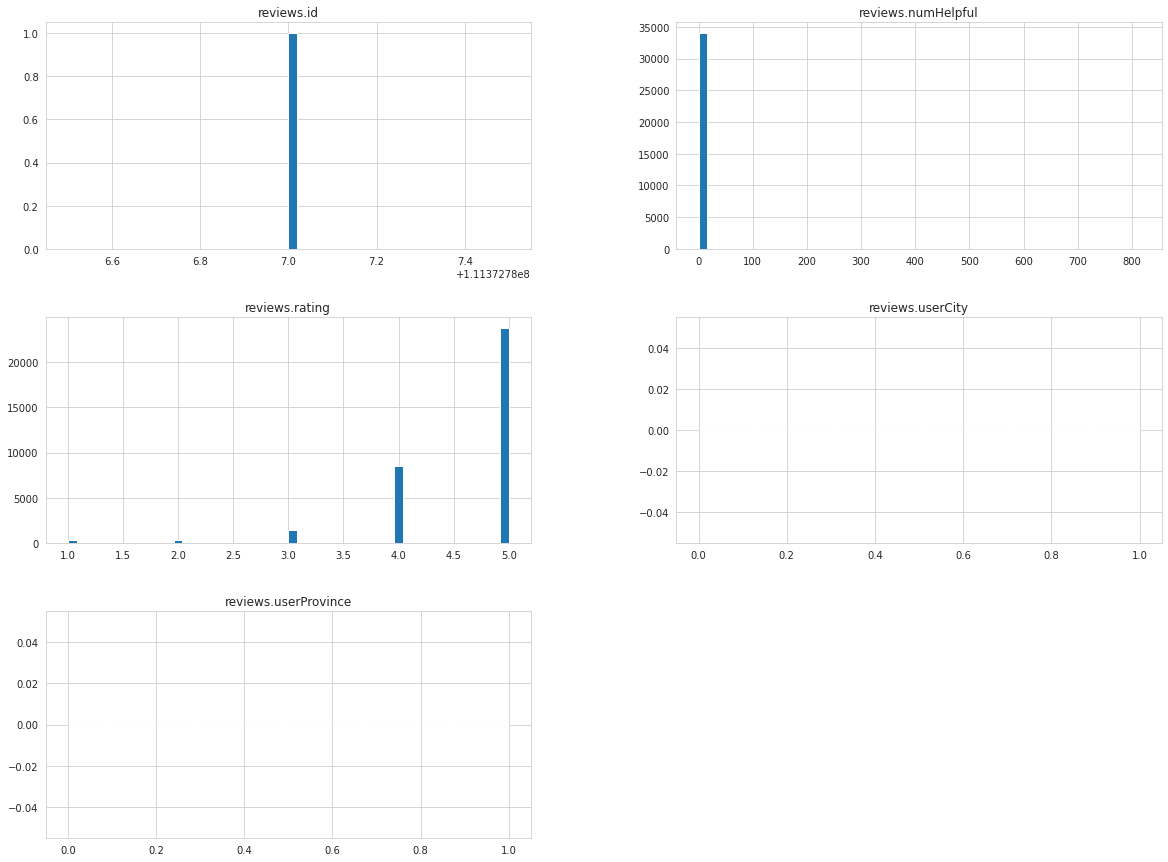

In [11]:
data.hist(bins=50, figsize=(20,15))
plt.show()

**Outliers in this case are valuable, so we may want to weight reviews that had more than 50+ people who find them helpful.**

**Majority of examples were rated highly (looking at rating distribution). There is twice amount of 5 star ratings than the others ratings combined**.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["reviews.rating"])
# Removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["reviews.rating"].astype(int)

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter,
                                           dataAfter["reviews.rating"]):
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

Before 34660
After 34627


In [13]:
print(len(strat_train))
print(len(strat_test))
print(strat_test["reviews.rating"].value_counts()/len(strat_test))

27701
6926
5.0    0.689864
4.0    0.244730
3.0    0.042160
1.0    0.011406
2.0    0.011118
Name: reviews.rating, dtype: float64


In [15]:
reviews = strat_train.copy()
reviews.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
4349,AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B018Y229OU,Amazon,"Fire Tablets,Tablets,Computers & Tablets,All T...",firetablet7displaywifi8gbincludesspecialoffers...,Amazon,2015-11-28T00:00:00.000Z,2017-05-21T04:06:08Z,"2017-04-30T00:26:00.000Z,2017-06-07T08:10:00.000Z",NaN,True,NaN,5.0,5.0,http://reviews.bestbuy.com/3545/5025800/review...,we bought this for my 11 year old daughter and...,great for all ages,NaN,NaN,Mark
30776,AV1YE_muvKc47QAVgpwE,NaN,B00U3FPN4U,Amazon Fire Tv,"Back To College,College Electronics,College Tv...","848719057492,amazonfiretv/51454342,amazonfiret...",Amazon,2017-01-06T00:00:00.000Z,2017-09-20T05:35:55Z,"2017-08-25T22:21:42.763Z,2017-08-19T09:26:46.1...",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/4370400/review...,"I have the Roku 4, and new Apple TV, this stre...",Great streaming box,NaN,NaN,Techno
28775,AVpidLjVilAPnD_xEVpI,NaN,B0189XYY0Q,Amazon Fire,"Electronics,Tablets & E-Readers,Tablets,Back T...","841667101743,amazonfire/51441641,amazonfirehd1...",Amazon,2017-03-11T00:00:00.000Z,NaN,"2017-09-03T08:45:20.825Z,2017-08-27T11:01:01.1...",NaN,False,NaN,0.0,3.0,http://reviews.bestbuy.com/3545/5386601/review...,This is my 3rd Kindle. I have continued to mov...,My 3rd Kindle,NaN,NaN,Sunshine
1136,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-02-04T00:00:00.000Z,2017-05-21T05:56:10Z,"2017-04-30T00:42:00.000Z,2017-06-07T09:04:00.000Z",NaN,True,NaN,1.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,enjoying reading via the device; lots of optio...,easy to use; a little heavy to hold,NaN,NaN,bird
17803,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,B00OQVZDJM,Amazon,"Walmart for Business,Office Electronics,Tablet...","amazon/b00oqvzdjm,848719056099,amazonkindlepap...",Amazon,2015-10-22T00:00:00.000Z,2017-09-05T22:09:30Z,"2017-08-31T22:34:06.437Z,2017-08-02T19:49:50.3...",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/9439005/review...,"If you want an e book reader that is light, ea...",As an e reader this is great!,NaN,NaN,Thomas


In [16]:
print(len(reviews["name"].unique()), len(reviews["asins"].unique()))
print(reviews.info())
print(reviews.groupby("asins")["name"].unique())

47 35
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27701 entries, 4349 to 29636
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    27673 non-null  object 
 1   name                  22268 non-null  object 
 2   asins                 27672 non-null  object 
 3   brand                 27673 non-null  object 
 4   categories            27673 non-null  object 
 5   keys                  27673 non-null  object 
 6   manufacturer          27673 non-null  object 
 7   reviews.date          27659 non-null  object 
 8   reviews.dateAdded     19228 non-null  object 
 9   reviews.dateSeen      27673 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   27257 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    27304 non-null  float64
 14  reviews.rating        27673 non-null  float64
 15  reviews.so

In [17]:
# Lets see all the different names for this product that have 2 ASINs
different_names = reviews[reviews["asins"] ==
                          "B00L9EPT8O,B01E6AO69U"]["name"].unique()
for name in different_names:
    print(name)
print(reviews[reviews["asins"] == "B00L9EPT8O,B01E6AO69U"]["name"].value_counts())

Echo (White),,,
Echo (White),,,
Amazon Fire Tv,,,
Amazon Fire Tv,,,
nan
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,
Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,
Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red

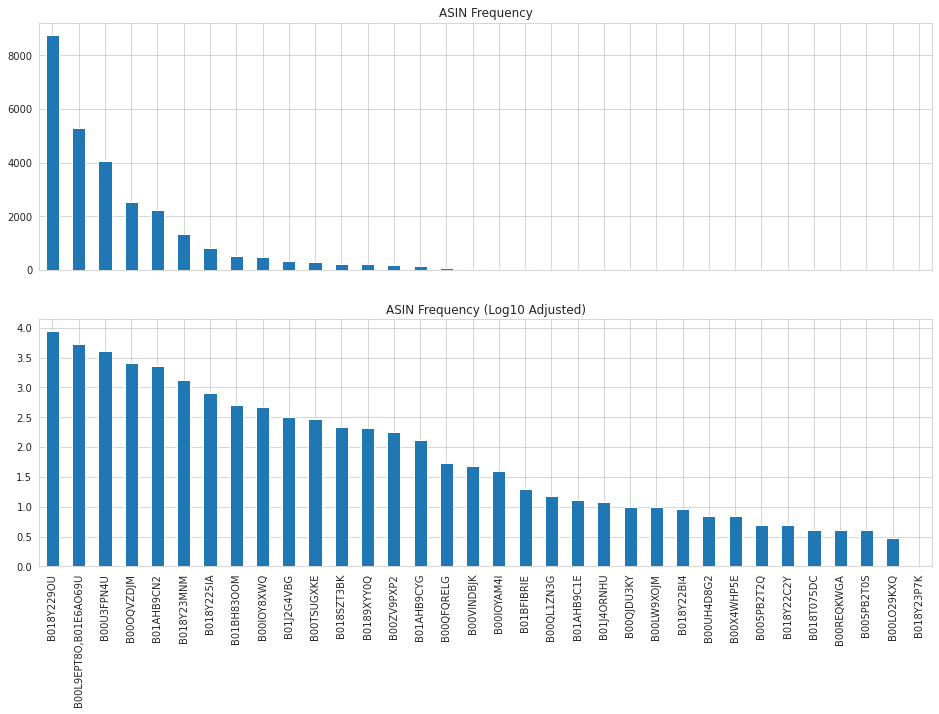

In [18]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
reviews["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")
np.log10(reviews["asins"].value_counts()).plot(kind="bar", ax=ax2,
                                               title="ASIN Frequency (Log10 Adjusted)")
plt.show()

4.5841072525566435


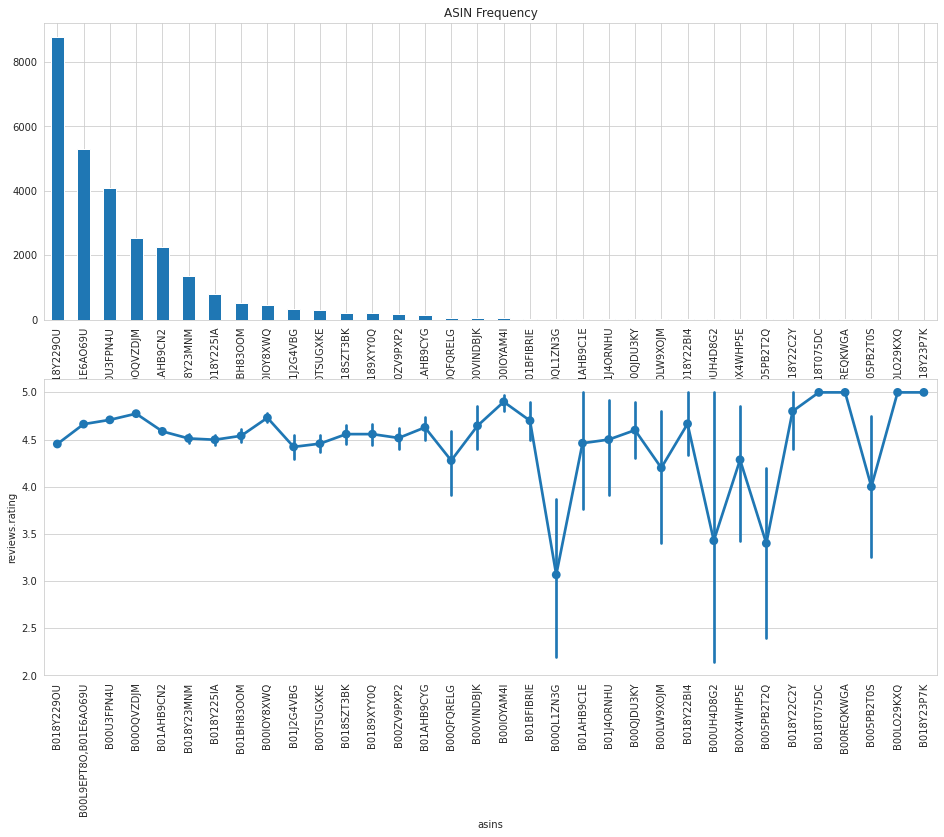

In [19]:
# Entire training dataset average rating
print(reviews["reviews.rating"].mean())

asins_count_ix = reviews["asins"].value_counts().index
plt.subplots(2,1,figsize=(16,12))
plt.subplot(2,1,1)
reviews["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=reviews)
plt.xticks(rotation=90)
plt.show()

In [20]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
strat_train["Sentiment"] = strat_train["reviews.rating"].apply(sentiments)
strat_test["Sentiment"] = strat_test["reviews.rating"].apply(sentiments)
print(strat_train["Sentiment"][:20])

4349     Positive
30776    Positive
28775     Neutral
1136     Positive
17803    Positive
7336     Positive
32638    Positive
13995    Positive
6728     Negative
22009    Positive
11047    Positive
22754    Positive
5578     Positive
11673    Positive
19168    Positive
14903    Positive
30843    Positive
5440     Positive
28940    Positive
31258    Positive
Name: Sentiment, dtype: object
